In [3]:
import pandas as pd
import numpy as np
import plotly.express as pe
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split # For spliting the data into train and test
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # For Hyperparameter Tunning for better model performance
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Model Tools
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier




pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:


# Load the dataset
df = pd.read_csv('Data\heart_disease_data.csv')

# Display the first few rows, column names, and basic info
head = df.head()
columns = df.columns.tolist()
info = df.info()
summary = df.describe()

head, columns, summary,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HeartDisease                319795 non-null  object 
 1   BMI                         319795 non-null  float64
 2   Smoking                     319795 non-null  object 
 3   AlcoholDrinking             212984 non-null  object 
 4   Stroke                      318683 non-null  object 
 5   PhysicalHealth              319795 non-null  float64
 6   MentalHealth                319795 non-null  float64
 7   DiffWalking                 319795 non-null  object 
 8   Sex                         319795 non-null  object 
 9   AgeCategory                 319795 non-null  object 
 10  Race                        319795 non-null  object 
 11  Diabetic                    319795 non-null  object 
 12  PhysicalActivity            319795 non-null  object 
 13  GenHealth     

(  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
 0           No  16.60     Yes              No     No             3.0   
 1           No  20.34      No             NaN    Yes             0.0   
 2           No  26.58     Yes             NaN     No            20.0   
 3           No  24.21      No             NaN     No             0.0   
 4           No  23.71      No              No     No            28.0   
 
    MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
 0          30.0          No  Female        55-59  White      Yes   
 1           0.0          No  Female  80 or older  White       No   
 2          30.0          No    Male        65-69  White      Yes   
 3           0.0          No  Female        75-79  White       No   
 4           0.0         Yes  Female        40-44  White       No   
 
   PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
 0              Yes  Very good        5.0    Yes            No     

In [5]:
df.head().T

,0,1,2,3,4
HeartDisease,No,No,No,No,No
BMI,16.6,20.34,26.58,24.21,23.71
Smoking,Yes,No,Yes,No,No
AlcoholDrinking,No,NaN,NaN,NaN,No
Stroke,No,Yes,No,No,No
PhysicalHealth,3.0,0.0,20.0,0.0,28.0
MentalHealth,30.0,0.0,30.0,0.0,0.0
DiffWalking,No,No,No,No,Yes
Sex,Female,Female,Male,Female,Female
AgeCategory,55-59,80 or older,65-69,75-79,40-44


In [6]:
# Step 1: Drop the high-missing column
df_cleaned = df.drop(columns=["HeartDisease_FamilyHistory"]) #HeartDisease_FamilyHistory has ~89% missing → not useful

df_cleaned["Diabetic"] = df_cleaned["Diabetic"].fillna("Unknown")

df_cleaned["Diabetic"] = df_cleaned["Diabetic"].map({
    "Yes": 1, "No": 0, "Unknown": -1, 
    "No, borderline diabetes": 0.5,
    "Yes (during pregnancy)": 0.75  # or encode however you'd like
})

# Step 2: Impute missing categorical values with 'Unknown'
columns_to_impute = ["AlcoholDrinking", "Stroke", "SkinCancer"]
df_cleaned[columns_to_impute] = df_cleaned[columns_to_impute].fillna("Unknown")

# Step 3: Encode binary columns: Yes/No → 1/0
binary_columns = [
    "HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking",
      "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"
]
for col in binary_columns:
    df_cleaned[col] = df_cleaned[col].map({"Yes": 1, "No": 0, "Unknown": -1})

# Step 4: One-hot encode multiclass categoricals
categorical_columns = ["Sex", "AgeCategory", "Race", "GenHealth", "State"]
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True).astype(float)

# Final check: Display shape and a sample
df.shape, df_encoded.shape, df_encoded.head()


((319795, 20),
 (319795, 87),
    HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
 0           0.0  16.60      1.0              0.0     0.0             3.0   
 1           0.0  20.34      0.0             -1.0     1.0             0.0   
 2           0.0  26.58      1.0             -1.0     0.0            20.0   
 3           0.0  24.21      0.0             -1.0     0.0             0.0   
 4           0.0  23.71      0.0              0.0     0.0            28.0   
 
    MentalHealth  DiffWalking  Diabetic  PhysicalActivity  SleepTime  Asthma  \
 0          30.0          0.0       1.0               1.0        5.0     1.0   
 1           0.0          0.0       0.0               1.0        7.0     0.0   
 2          30.0          0.0       1.0               1.0        8.0     1.0   
 3           0.0          0.0       0.0               0.0        6.0     0.0   
 4           0.0          1.0       0.0               1.0        8.0     0.0   
 
    KidneyDisease  SkinC

In [7]:
# Check for duplicated rows in the cleaned dataset
num_duplicates = df_encoded.duplicated().sum()
num_duplicates


313

In [8]:
# Drop duplicates
df_encoded = df_encoded.drop_duplicates()

In [9]:
#Class Distribution ---
class_counts = df_encoded['HeartDisease'].value_counts(normalize=True).reset_index()
class_counts.columns = ['HeartDisease', 'proportion']
class_counts['proportion'] = class_counts['proportion'].round(2)

# Find the color for the bar with the highest proportion
max_proportion_index = class_counts['proportion'].idxmax()
colors = ['#3498db' if i != max_proportion_index else '#e74c3c' for i in range(len(class_counts))]
fig1 = go.Figure(data=[go.Bar(
    # x=["No", "Yes"],
    # y=class_counts.values,
    # marker_color=['lightskyblue', 'salmon']
    x=class_counts['HeartDisease'],
    y=class_counts['proportion'],
    marker_color=colors,
    text=class_counts['proportion'],
    opacity=0.75,
)])

fig1.update_layout(
    title="Heart Disease Class Distribution",
    xaxis_title="Heart Disease",
    yaxis_title="Fractionality Proportion %"
)

In [10]:
#Correlation Heatmap ---
corr_matrix = df_encoded.corr(numeric_only=True).round(2)
heatmap = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='Viridis',
    colorbar=dict(title="Correlation")
))
heatmap.update_layout(title="Correlation Heatmap")

In [11]:
 #Top Correlated Features ---
target_corr = corr_matrix["HeartDisease"].drop("HeartDisease").sort_values()
top_corr = pd.concat([target_corr.head(5), target_corr.tail(5)])
bar = go.Figure(data=go.Bar(
    x=top_corr.values,
    y=top_corr.index,
    orientation='h',
    marker_color='steelblue'
))
bar.update_layout(
    title="Top Features Correlated with Heart Disease",
    xaxis_title="Correlation Coefficient",
    yaxis_title="Feature"
)


bar.show()

In [12]:
# Separate features and target
X = df_encoded.drop(columns=["HeartDisease"])
y = df_encoded["HeartDisease"]

# Class distribution
class_distribution = y.value_counts(normalize=True) * 100

# Correlation with target
correlation_with_target = df_encoded.corr(numeric_only=True)["HeartDisease"].sort_values(ascending=False)

# Top positively and negatively correlated features
top_positive_corr = correlation_with_target[1:6]
top_negative_corr = correlation_with_target[-5:]

class_distribution, top_positive_corr, top_negative_corr

(HeartDisease
 0.0    91.432068
 1.0     8.567932
 Name: proportion, dtype: float64,
 DiffWalking       0.201163
 Stroke            0.188370
 Diabetic          0.179474
 GenHealth_Poor    0.174616
 PhysicalHealth    0.170617
 Name: HeartDisease, dtype: float64,
 AgeCategory_25-29     -0.065805
 AgeCategory_35-39     -0.066723
 AgeCategory_18-24     -0.075436
 PhysicalActivity      -0.099896
 GenHealth_Very good   -0.101855
 Name: HeartDisease, dtype: float64)

>Imbalance dataset.In binary classification, we typically want a fairly even distribution of the two classes. But in your case:

HeartDisease = No: 91.4% of samples

HeartDisease = Yes: 8.6% of samples

That means the model could predict "No" all the time and still be 91% accurate, but completely useless in detecting actual heart disease cases — which are the most important to catch!


In [13]:
# plotting the distribution of the "HeartDisease" column(Target variable)
# # Compute the class distribution (counts and proportions)
# class_distribution = y.value_counts(normalize=True).reset_index()
# class_distribution.columns = ['HeartDisease', 'proportion']
# class_distribution['proportion'] = class_distribution['proportion'].round(2)

# # Find the color for the bar with the highest proportion
# max_proportion_index = class_distribution['proportion'].idxmax()
# colors = ['#3498db' if i != max_proportion_index else '#e74c3c' for i in range(len(class_distribution))]

# # Generating the plot
# fig_heartDisease = go.Figure()
# fig_heartDisease.add_trace(go.Bar(
#                  x=class_distribution['HeartDisease'],
#                  y=class_distribution['proportion'],
#                  marker_color=colors,
#                  text=class_distribution['proportion'],
#                  opacity=0.75),                         
# )
# fig_heartDisease.update_layout(
#     title='Heart Disease Distribution',
#     xaxis_title='Heart Disease',
#     yaxis_title='Fractionality Proportion %',
#     showlegend=False  # No legend for a single distribution plot
# )
# fig_heartDisease.show()

In [14]:
# nan_columns = X.columns[X.isnull().any()].tolist()

# # print(X.isnull().values.any())
# print(nan_columns)

In [15]:
# # For a single column
# nan_count = X["Diabetic"].isnull().sum()
# print("NaN count in 'Diabetic':", nan_count)

# # Check if the column has any NaN at all
# has_nan = X["Diabetic"].isnull().any()
# print("Does 'Diabetic' have NaN?", has_nan)

In [16]:
# # Check for remaining missing values
# print(X.isnull().sum()[X.isnull().sum() > 0])

# # # Option 1: Fill numeric NaNs with column means
# # X = X.fillna(X.mean(numeric_only=True))

# # # Option 2: Or drop rows with missing values (if minimal)
# # # X = X.dropna()


## Modelling


### Logistic Regression

In [17]:
# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Step 2: Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Logistic Regression with class weights
model_weighted = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = model_weighted.predict(X_test_scaled)
y_proba_weighted = model_weighted.predict_proba(X_test_scaled)[:, 1]

report_weighted = classification_report(y_test, y_pred_weighted, output_dict=True)
auc_weighted = roc_auc_score(y_test, y_proba_weighted)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
# -----------------------------
# Logistic Regression with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

model_smote = LogisticRegression(max_iter=1000, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test_scaled)
y_proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]

report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
auc_smote = roc_auc_score(y_test, y_proba_smote)
cm_smote = confusion_matrix(y_test, y_pred_smote)

report_weighted, auc_weighted,cm_weighted, report_smote, auc_smote, cm_smote


({'0.0': {'precision': 0.9734135324896024,
   'recall': 0.7451473759884975,
   'f1-score': 0.8441208407663073,
   'support': 58422.0},
  '1.0': {'precision': 0.22352020860495436,
   'recall': 0.7828310502283105,
   'f1-score': 0.34774847870182557,
   'support': 5475.0},
  'accuracy': 0.7483762930967025,
  'macro avg': {'precision': 0.5984668705472784,
   'recall': 0.763989213108404,
   'f1-score': 0.5959346597340665,
   'support': 63897.0},
  'weighted avg': {'precision': 0.909159092558644,
   'recall': 0.7483762930967025,
   'f1-score': 0.8015892871361989,
   'support': 63897.0}},
 0.8385833165682097,
 array([[43533, 14889],
        [ 1189,  4286]], dtype=int64),
 {'0.0': {'precision': 0.9731370911307253,
   'recall': 0.7378898360206771,
   'f1-score': 0.8393415173138891,
   'support': 58422.0},
  '1.0': {'precision': 0.218644759669354,
   'recall': 0.782648401826484,
   'f1-score': 0.3418019383400471,
   'support': 5475.0},
  'accuracy': 0.7417249636133152,
  'macro avg': {'precision

In [18]:

# Predictions and probability scores from class-weighted model
report_weighted_summary = {
    "Precision (1)": report_weighted["1.0"]["precision"], # How many predicted positive are actually positive
    "Recall (1)": report_weighted["1.0"]["recall"],  # How well we identify the target
    "F1-score (1)": report_weighted["1.0"]["f1-score"],  # Balance between the Recall and Precision
    "Accuracy": report_weighted["accuracy"],
    "AUC-ROC": auc_weighted ,    # Overall performance metric for imbalance data
    # "confusion_matrix" : cm_weighted
}

report_weighted_summary


{'Precision (1)': 0.22352020860495436,
 'Recall (1)': 0.7828310502283105,
 'F1-score (1)': 0.34774847870182557,
 'Accuracy': 0.7483762930967025,
 'AUC-ROC': 0.8385833165682097}

In [19]:
# Predictions and probability scores from SMOTE model
report_smote_summary = {
    "Precision (1)": report_smote["1.0"]["precision"],
    "Recall (1)": report_smote["1.0"]["recall"],
    "F1-score (1)": report_smote["1.0"]["f1-score"],
    "Accuracy": report_smote["accuracy"],
    "AUC-ROC": auc_smote
}

report_smote_summary

{'Precision (1)': 0.218644759669354,
 'Recall (1)': 0.782648401826484,
 'F1-score (1)': 0.3418019383400471,
 'Accuracy': 0.7417249636133152,
 'AUC-ROC': 0.8350686901115782}

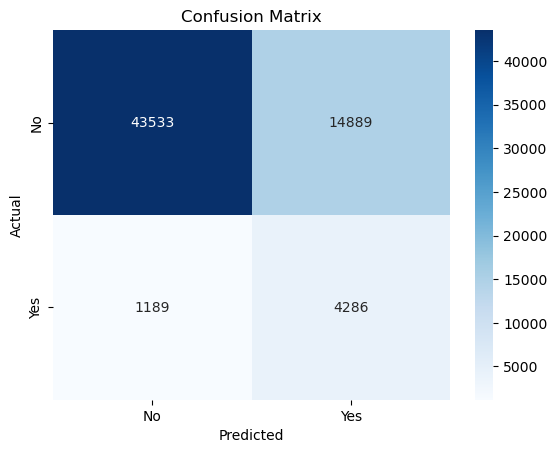

In [20]:
#Confusion Matrix plot Class weighted
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

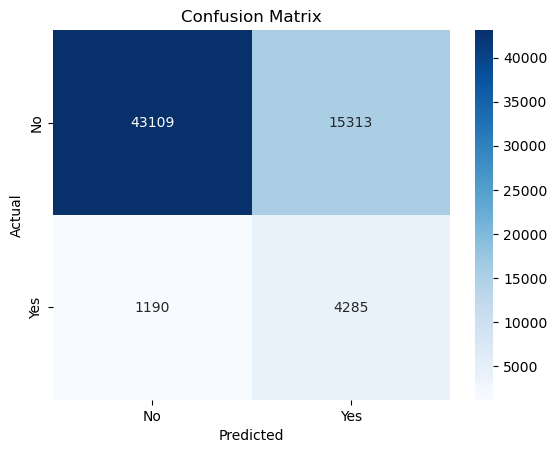

In [21]:
#Confusion Matrix plot SMOTE
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

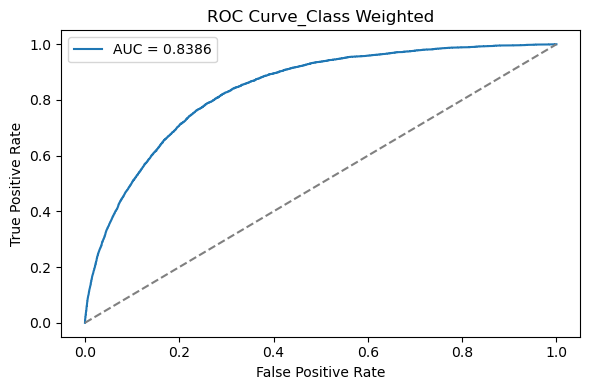

In [22]:
fpr_weighted, tpr_weighted, _weighted = roc_curve(y_test, y_proba_weighted)
plt.figure(figsize=(6,4))
plt.plot(fpr_weighted, tpr_weighted, label=f"AUC = {auc_weighted:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve_Class Weighted")
plt.legend()
plt.tight_layout()
plt.show()

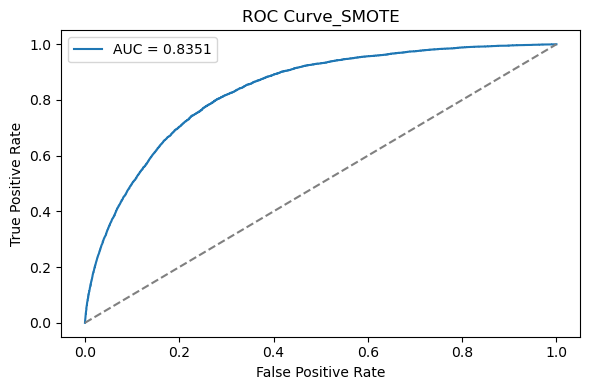

In [23]:
fpr_smote, tpr_smote, _smote = roc_curve(y_test, y_proba_smote)
plt.figure(figsize=(6,4))
plt.plot(fpr_smote, tpr_smote, label=f"AUC = {auc_smote:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve_SMOTE")
plt.legend()
plt.tight_layout()
plt.show()

## Decision tree Model

<BarContainer object of 10 artists>

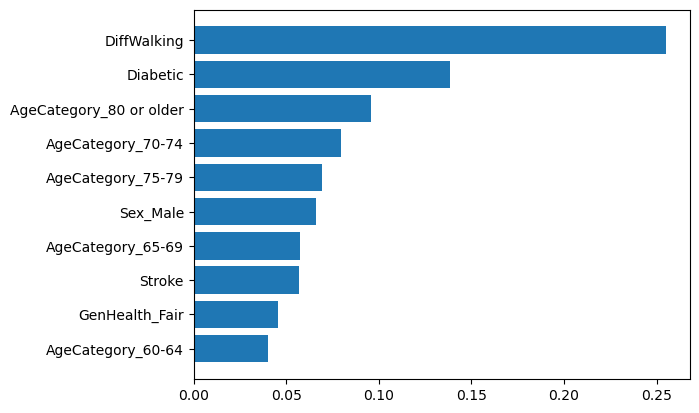

In [24]:
# Model with Decision Tree
# Instatiating Decision Tree model
model_Decision= DecisionTreeClassifier(class_weight='balanced', max_depth= 9, min_samples_leaf=4, random_state=42)
model_Decision.fit(X_train_scaled, y_train)
sorted_idx = model_Decision.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model_Decision.feature_importances_[sorted_idx][-10:])


In [25]:
y_pred_Decision = model_Decision.predict(X_test_scaled)
y_proba_Decision = model_Decision.predict_proba(X_test_scaled)[:, 1]

report_Decision = classification_report(y_test, y_pred_Decision, output_dict=True)
auc_Decision = roc_auc_score(y_test, y_proba_Decision)
cm_Decision = confusion_matrix(y_test, y_pred_Decision)

report_Decision, auc_Decision, cm_Decision

({'0.0': {'precision': 0.9710364432845559,
   'recall': 0.7133100544315497,
   'f1-score': 0.8224555448104364,
   'support': 58422.0},
  '1.0': {'precision': 0.20170630570516182,
   'recall': 0.7729680365296804,
   'f1-score': 0.3199274266706985,
   'support': 5475.0},
  'accuracy': 0.7184218351409299,
  'macro avg': {'precision': 0.5863713744948589,
   'recall': 0.743139045480615,
   'f1-score': 0.5711914857405674,
   'support': 63897.0},
  'weighted avg': {'precision': 0.9051165643661845,
   'recall': 0.7184218351409299,
   'f1-score': 0.7793965366126325,
   'support': 63897.0}},
 0.8025069416991064,
 array([[41673, 16749],
        [ 1243,  4232]], dtype=int64))

In [26]:
# Predictions and probability scores from Decision Tree model
report_Decision_summary = {
    "Precision (1)": report_Decision["1.0"]["precision"], # How many predicted positive are actually positive
    "Recall (1)": report_Decision["1.0"]["recall"],  # How well we identify the target
    "F1-score (1)": report_Decision["1.0"]["f1-score"],  # Balance between the Recall and Precision
    "Accuracy": report_Decision["accuracy"],
    "AUC-ROC": auc_Decision ,    # Overall performance metric for imbalance data
    # "confusion_matrix" : cm_Decision
}

report_Decision_summary

{'Precision (1)': 0.20170630570516182,
 'Recall (1)': 0.7729680365296804,
 'F1-score (1)': 0.3199274266706985,
 'Accuracy': 0.7184218351409299,
 'AUC-ROC': 0.8025069416991064}

### Random Forest Model

In [27]:
# Model with Random Forest
# Instatiating Random Forest model
model_RandomForest= RandomForestClassifier( n_estimators= 50,random_state=42, class_weight="balanced", max_depth= 15, min_samples_leaf=5)
model_RandomForest.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, n_estimators=50, random_state=42)

<BarContainer object of 10 artists>

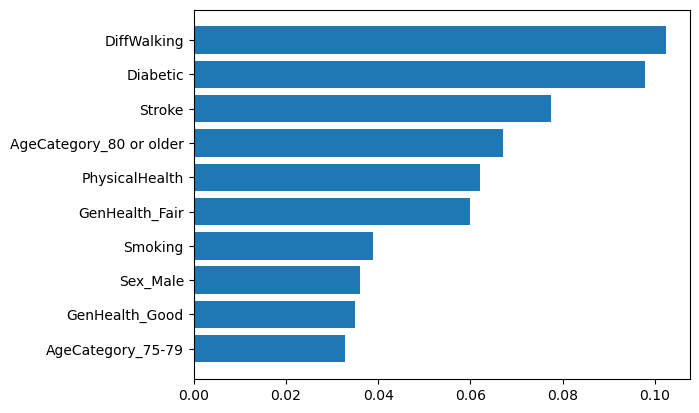

In [28]:
sorted_idx = model_RandomForest.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model_RandomForest.feature_importances_[sorted_idx][-10:])

In [29]:
y_pred_RandomForest = model_RandomForest.predict(X_test_scaled)
y_proba_RandomForest = model_RandomForest.predict_proba(X_test_scaled)[:, 1]

report_RandomForest = classification_report(y_test, y_pred_RandomForest, output_dict=True)
auc_RandomForest = roc_auc_score(y_test, y_proba_RandomForest)
cm_RandomForest = confusion_matrix(y_test, y_pred_RandomForest)

report_RandomForest, auc_RandomForest, cm_RandomForest

({'0.0': {'precision': 0.9707531444158206,
   'recall': 0.7675533189551881,
   'f1-score': 0.857276681164269,
   'support': 58422.0},
  '1.0': {'precision': 0.23294170808856757,
   'recall': 0.7532420091324201,
   'f1-score': 0.355839337331205,
   'support': 5475.0},
  'accuracy': 0.7663270576083384,
  'macro avg': {'precision': 0.6018474262521941,
   'recall': 0.7603976640438042,
   'f1-score': 0.606558009247737,
   'support': 63897.0},
  'weighted avg': {'precision': 0.9075339382889022,
   'recall': 0.7663270576083384,
   'f1-score': 0.8143111357163446,
   'support': 63897.0}},
 0.8367296113039295,
 array([[44842, 13580],
        [ 1351,  4124]], dtype=int64))

In [30]:
# Predictions and probability scores from Random Forest model
report_RandomForest_summary = {
    "Precision (1)": report_RandomForest["1.0"]["precision"], # How many predicted positive are actually positive
    "Recall (1)": report_RandomForest["1.0"]["recall"],  # How well we identify the target
    "F1-score (1)": report_RandomForest["1.0"]["f1-score"],  # Balance between the Recall and Precision
    "Accuracy": report_RandomForest["accuracy"],
    "AUC-ROC": auc_RandomForest,     # Overall performance metric for imbalance data
    # "confusion_matrix": cm_RandomForest
}

report_RandomForest_summary

{'Precision (1)': 0.23294170808856757,
 'Recall (1)': 0.7532420091324201,
 'F1-score (1)': 0.355839337331205,
 'Accuracy': 0.7663270576083384,
 'AUC-ROC': 0.8367296113039295}

## Gradient Boosting Model

In [31]:
# Model with Gradient Boosting
# Instatiating Gradient Boosting model
model_GradientBoosting= GradientBoostingClassifier( n_estimators= 50,random_state=42,  max_depth= 15, min_samples_leaf=5)
model_GradientBoosting.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=15, min_samples_leaf=5, n_estimators=50,
                           random_state=42)

<BarContainer object of 10 artists>

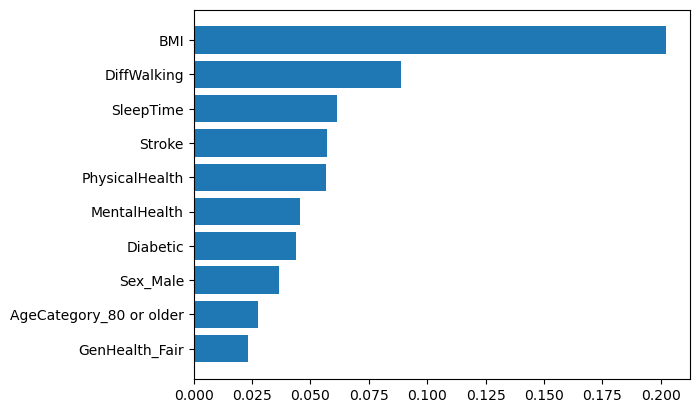

In [32]:
sorted_idx = model_GradientBoosting.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model_GradientBoosting.feature_importances_[sorted_idx][-10:])

In [33]:
y_pred_GradientBoosting = model_GradientBoosting.predict(X_test_scaled)
y_proba_GradientBoosting = model_GradientBoosting.predict_proba(X_test_scaled)[:, 1]

report_GradientBoosting = classification_report(y_test, y_pred_GradientBoosting, output_dict=True)
auc_GradientBoosting = roc_auc_score(y_test, y_proba_GradientBoosting)
cm_GradientBoosting = confusion_matrix(y_test, y_pred_GradientBoosting)

report_GradientBoosting, auc_GradientBoosting, cm_GradientBoosting

({'0.0': {'precision': 0.9232607754126497,
   'recall': 0.9851939337920647,
   'f1-score': 0.9532224273991206,
   'support': 58422.0},
  '1.0': {'precision': 0.4440874035989717,
   'recall': 0.12621004566210045,
   'f1-score': 0.19655809984355,
   'support': 5475.0},
  'accuracy': 0.9115920935255176,
  'macro avg': {'precision': 0.6836740895058107,
   'recall': 0.5557019897270825,
   'f1-score': 0.5748902636213353,
   'support': 63897.0},
  'weighted avg': {'precision': 0.8822029133740581,
   'recall': 0.9115920935255176,
   'f1-score': 0.8883878155493193,
   'support': 63897.0}},
 0.823739529222822,
 array([[57557,   865],
        [ 4784,   691]], dtype=int64))

In [34]:
# Predictions and probability scores from Gradient Boosting model
report_GradientBoosting_summary = {
    "Precision (1)": report_GradientBoosting["1.0"]["precision"], # How many predicted positive are actually positive
    "Recall (1)": report_GradientBoosting["1.0"]["recall"],  # How well we identify the target
    "F1-score (1)": report_GradientBoosting["1.0"]["f1-score"],  # Balance between the Recall and Precision
    "Accuracy": report_GradientBoosting["accuracy"],
    "AUC-ROC": auc_GradientBoosting ,   # Overall performance metric for imbalance data
    # "confusion_matrix" : cm_GradientBoosting
}

report_GradientBoosting_summary

{'Precision (1)': 0.4440874035989717,
 'Recall (1)': 0.12621004566210045,
 'F1-score (1)': 0.19655809984355,
 'Accuracy': 0.9115920935255176,
 'AUC-ROC': 0.823739529222822}

## XG Boost Mode

In [35]:
# Model with XG Boosting
# Instatiating XG Boosting model
model_XGBoost= XGBClassifier( 
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(), 
    eval_metric='logloss', 
    random_state= 42,
    n_estimators = 50,
    max_depth = 15,
    )
model_XGBoost.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

<BarContainer object of 10 artists>

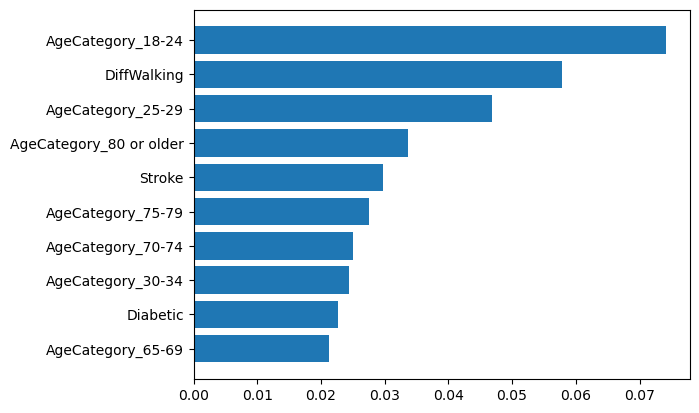

In [36]:
sorted_idx = model_XGBoost.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model_XGBoost.feature_importances_[sorted_idx][-10:])

In [37]:
y_pred_XGBoost = model_XGBoost.predict(X_test_scaled)
y_proba_XGBoost = model_XGBoost.predict_proba(X_test_scaled)[:, 1]

report_XGBoost = classification_report(y_test, y_pred_XGBoost, output_dict=True)
auc_XGBoost = roc_auc_score(y_test, y_proba_XGBoost)
cm_XGBoost = confusion_matrix(y_test, y_pred_XGBoost)

report_XGBoost, auc_XGBoost, cm_XGBoost

({'0.0': {'precision': 0.9467654986522911,
   'recall': 0.8657697442744172,
   'f1-score': 0.9044579153478891,
   'support': 58422.0},
  '1.0': {'precision': 0.25121741621311944,
   'recall': 0.48054794520547944,
   'f1-score': 0.3299473288186606,
   'support': 5475.0},
  'accuracy': 0.832762101507113,
  'macro avg': {'precision': 0.5989914574327053,
   'recall': 0.6731588447399484,
   'f1-score': 0.6172026220832749,
   'support': 63897.0},
  'weighted avg': {'precision': 0.8871676184489253,
   'recall': 0.832762101507113,
   'f1-score': 0.8552311056189891,
   'support': 63897.0}},
 0.7884735358810382,
 array([[50580,  7842],
        [ 2844,  2631]], dtype=int64))

In [38]:
# Predictions and probability scores from XG Boosting model
report_XGBoost_summary = {
    "Precision (1)": report_XGBoost["1.0"]["precision"], # How many predicted positive are actually positive
    "Recall (1)": report_XGBoost["1.0"]["recall"],  # How well we identify the target
    "F1-score (1)": report_XGBoost["1.0"]["f1-score"],  # Balance between the Recall and Precision
    "Accuracy": report_XGBoost["accuracy"],
    "AUC-ROC": auc_XGBoost,   # Overall performance metric for imbalance data
    # "confusion_matrix" : cm_XGBoost
}

report_XGBoost_summary

{'Precision (1)': 0.25121741621311944,
 'Recall (1)': 0.48054794520547944,
 'F1-score (1)': 0.3299473288186606,
 'Accuracy': 0.832762101507113,
 'AUC-ROC': 0.7884735358810382}

In [39]:
# Model Result

Model_results = {
    "Logistic Regression": report_weighted_summary,
    "Decision Tree": report_Decision_summary,
    "Random Forest": report_RandomForest_summary,
    "Gradient Boosting": report_GradientBoosting_summary,
    "XG Boost": report_XGBoost_summary
}
Model_results
 # Convert to DataFrame
results_df = pd.DataFrame(Model_results).T
results_df = results_df.round(4).sort_values("AUC-ROC", ascending=False)
results_df

,Precision (1),Recall (1),F1-score (1),Accuracy,AUC-ROC
Logistic Regression,0.2235,0.7828,0.3477,0.7484,0.8386
Random Forest,0.2329,0.7532,0.3558,0.7663,0.8367
Gradient Boosting,0.4441,0.1262,0.1966,0.9116,0.8237
Decision Tree,0.2017,0.7730,0.3199,0.7184,0.8025
XG Boost,0.2512,0.4805,0.3299,0.8328,0.7885


In [40]:
metrics = results_df.columns.tolist()

fig = go.Figure()

for model in results_df.index:
    fig.add_trace(go.Bar(
        x=metrics,
        y=results_df.loc[model],
        name=model
    ))

fig.update_layout(
    title="Model Comparison by Evaluation Metrics",
    xaxis_title="Metric",
    yaxis_title="Score",
    barmode='group',
    template="plotly_white"
)

fig.show()

In [41]:
# Style the DataFrame to highlight the best AUC-ROC score
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: lightgreen; font-weight: bold' if v else '' for v in is_max]

styled_df = results_df.style.apply(highlight_best, subset=["AUC-ROC"])

# Display the styled table 
styled_df


,Precision (1),Recall (1),F1-score (1),Accuracy,AUC-ROC
Logistic Regression,0.223500,0.782800,0.347700,0.748400,0.838600
Random Forest,0.232900,0.753200,0.355800,0.766300,0.836700
Gradient Boosting,0.444100,0.126200,0.196600,0.911600,0.823700
Decision Tree,0.201700,0.773000,0.319900,0.718400,0.802500
XG Boost,0.251200,0.480500,0.329900,0.832800,0.788500


# Evaluation of the best model


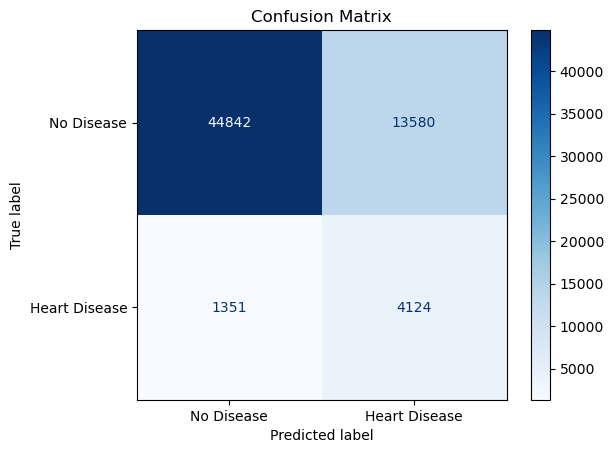

In [42]:
# Model is already trained and  have predictions
ConfusionMatrixDisplay.from_predictions(y_test, model_RandomForest.predict(X_test_scaled),
                                        display_labels=['No Disease', 'Heart Disease'],
                                        cmap='Blues',
                                        values_format='d')
plt.title("Confusion Matrix")
plt.show()


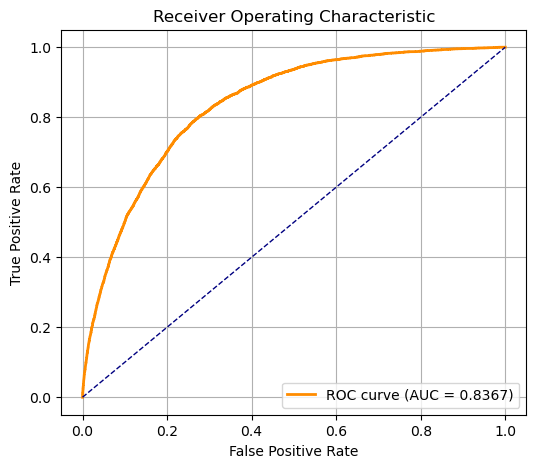

In [43]:
y_prob = model_RandomForest.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Hyperparameter for tuning the best Model

In [44]:

rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=rf_param_dist,
    n_iter=10,  # Try 10 random combinations instead of all
    scoring='roc_auc',
    cv=3,       # Reduce folds to 3 to speed up
    n_jobs=-1,
    verbose=1
)
rf_random.fit(X_train_scaled, y_train)

print("Best Parameters (Random Search):", rf_random.best_params_)
print("Best AUC:", rf_random.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters (Random Search): {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Best AUC: 0.8365051501684714


In [45]:
rf_param_grid = {
    'n_estimators': [200],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_scaled, y_train)
print("Best RF Parameters:", rf_grid.best_params_)
print("Best ROC AUC:", rf_grid.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best RF Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best ROC AUC: 0.8361780439429204


In [ ]:
# Retraining the Best Model with Best Parameters
final_model = RandomForestClassifier(**rf_grid.best_params_, class_weight='balanced', random_state=42)
final_model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

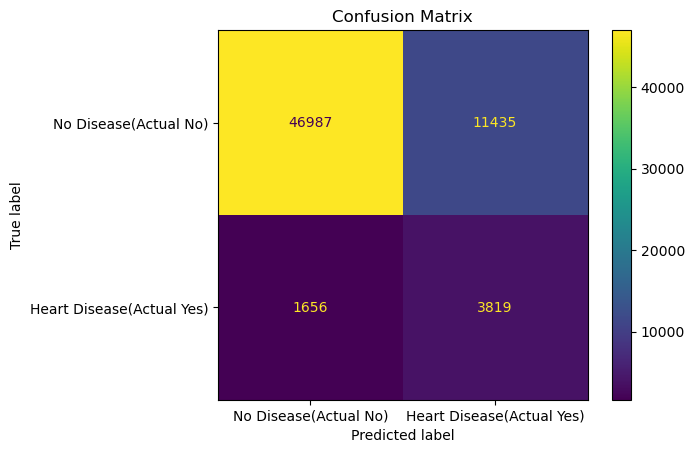

In [56]:
# Final Evaluation (Test Set)
ConfusionMatrixDisplay.from_predictions(y_test, final_model.predict(X_test_scaled),
                                        display_labels=['No Disease(Actual No)', 'Heart Disease(Actual Yes)'],
                                        cmap='viridis',
                                        values_format='d')
plt.title("Confusion Matrix")
plt.show()